In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle as skshuffle
import numpy as np
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import torchvision
%matplotlib inline

In [0]:
class CNN(nn.Module):
    def __init__(self, pool='max'):
        super(CNN, self).__init__()
         
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
         
        if pool=='max':
          self.pool1 = nn.MaxPool2d(kernel_size=2)
          self.pool2 = nn.MaxPool2d(kernel_size=2)

        else:
          self.pool1 = nn.AvgPool2d(kernel_size=2)
          self.pool2 = nn.AvgPool2d(kernel_size=2)
          
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU() 
         
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x) 
        out = self.relu1(out) 
         
        out = self.pool1(out) 
         
        # Convolution 2 
        out = self.cnn2(out) 
        out = self.relu2(out) 
         
        out = self.pool2(out) 
        out = out.view(out.size(0), -1)   
 
        # Linear function (readout)
        out = self.fc1(out)
         
        return out
      
    def output_cnn(self, x):
      out1 = self.cnn1(x)
      out2 = self.relu1(out1)          
      out2 = self.pool1(out2) 

      # Convolution 2 
      out2 = self.cnn2(out2) 

      return out1, out2    

In [0]:
class ModelEvaluator:
    def __init__(self, model, epochs, lr, l2=0.0, use_gpu=False, optim='adam'):
        '''
        model: instance of pytorch model class
        epochs: number of training epochs
        lr: learning rate
        use_gpu: to use gpu
        optim: optimizer used for training, SGD or adam
        '''
        self.epochs = epochs
        self.lr = lr
        self.model = model
        self.l2 = l2
        self.use_gpu = use_gpu
        self.train_loss = []
        self.test_loss = []

        if self.use_gpu:
            self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

            if self.device == 'cuda:0':
                if torch.cuda.device_count()>1:
                    self.model = nn.DataParallel(model)
                self.model.to(device)

        if optim=='adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        elif optim=='sgd':
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr = lr, momentum=0.9)
        elif optim=='adadelta':
            self.optimizer = torch.optim.Adadelta(self.model.parameters(), lr = lr, eps=1e-6, weight_decay=0)
        elif optim=='adagrad':
            self.optimizer = torch.optim.Adagrad(self.model.parameters(), lr = lr, lr_decay=1e-6, weight_decay=0)
        elif optim=='rmsprop':
            self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr = lr, alpha=0.995, eps=1e-7, weight_decay=0)
        else:
            ValueError('Optimizer Not Supported')

    def l2_regularization(self, loss, lam):
        l2 = 0
        for W in self.model.parameters():
            l2 += W.norm(2)
        loss = loss + 0.5*lam*l2
        return loss	


    def train(self, epoch, trainloader, print_every=100):
        '''
        method for training
        '''
        loss_batch = 0
        for b_idx, (train_data, train_labels) in enumerate(trainloader):
            if self.use_gpu and self.device == 'cuda:0':
                train_data, train_labels = train_data.to(self.device), train_labels.to(self.device)

            # Forward Pass 
            train_preds = self.model.forward(train_data)
            loss = self.model.loss(train_preds, train_labels)
            if self.l2:
                loss = self.l2_regularization(loss, self.l2)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if b_idx%print_every == 0:
                print('Train Epoch: {0} [{1}/{2} ({3:.0f}%)]\t Loss {4:.6f}'.
                    format(epoch, b_idx*len(train_data), len(trainloader.dataset), 
                        100.*b_idx/len(trainloader), loss))

            loss_batch += loss
        loss_batch /= len(trainloader)
        self.train_loss.append(loss_batch)    

    def validation(self, valloader):
        '''
        method for validation
        '''
        correct_, total_ = 0, 0
        with torch.no_grad():
            loss = 0
            for val_data, val_labels in valloader:
                if self.use_gpu and self.device == 'cuda:0':
                    val_data, val_labels = test_data.to(self.device), val_labels.to(self.device)
                val_preds = self.model.forward(val_data)

                loss += self.model.loss(val_preds, val_labels)

                _, val_pred_labels = torch.max(val_preds.data, 1)
                total_ += val_labels.size(0)
                correct_ += (val_pred_labels.cpu() == val_labels.cpu()).sum()

            loss /= len(valloader)
            self.val_loss.append(loss)
            accuracy_val = (100.0*correct_/total_)
            print('Validation Loss {1:.2f} Accuracy on validation set {2:.2f}'.format(loss, accuracy_val))
            return accuracy_val

    def test(self, testloader):
        '''
        method for testing
        '''
        correct_, total_ = 0, 0
        with torch.no_grad():
            loss = 0
            for test_data, test_labels in testloader:
                if self.use_gpu and self.device == 'cuda:0':
                    test_data, test_labels = test_data.to(self.device), test_labels.to(self.device)
                test_preds = self.model.forward(test_data)

                loss += self.model.loss(test_preds, test_labels)
                _, test_pred_labels = torch.max(test_preds.data, 1)
                total_ += test_labels.size(0)
                correct_ += (test_pred_labels.cpu() == test_labels.cpu()).sum()

            loss /= len(testloader)
            self.test_loss.append(loss)
            accuracy_test = (100*correct_/total_)
            print('Accuracy of model on test set {0:.2f}'.format(accuracy_test))
            return accuracy_test

    def evaluator(self, trainloader, testloader, print_every=1000, validation=False):
        for epoch in range(self.epochs):
            self.train(epoch, trainloader, print_every=print_every)
            if validation:
                acc_ = self.validation(testloader)
            else:
                acc_ = self.test(testloader)
        return acc_
    
    def plot_loss(self, validation=False):
        '''
        to visualize loss
        '''
        plt.plot(range(len(self.train_loss)), self.train_loss, label='Training Loss')
        if validation:
            plt.plot(range(len(self.val_loss)), self.val_loss, label='Validation Loss')
        else:
            plt.plot(range(len(self.test_loss)), self.test_loss, label='Testing Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [42]:
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Parameters
n_out = len(classes)
batch_size = 100

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# Hyperparameters
lr = 0.001
epochs = 10
# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [29]:
# Model
n_hidden = [1024, 512]
l2 = 0.0
pool = 'max'
# Pytorch Cross Entropy Loss
model = CNN(pool)
modeleval = ModelEvaluator(model, epochs, lr, l2=l2, use_gpu=True)
modeleval.evaluator(trainloader, testloader, print_every=100, validation=False)

Train Epoch: 0 [0/50000 (0%)]	 Loss 2.306387
Train Epoch: 0 [10000/50000 (20%)]	 Loss 1.937222
Train Epoch: 0 [20000/50000 (40%)]	 Loss 1.626268
Train Epoch: 0 [30000/50000 (60%)]	 Loss 1.641999
Train Epoch: 0 [40000/50000 (80%)]	 Loss 1.605598
Accuracy of model on test set 45.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 1.577814
Train Epoch: 1 [10000/50000 (20%)]	 Loss 1.462789
Train Epoch: 1 [20000/50000 (40%)]	 Loss 1.634140
Train Epoch: 1 [30000/50000 (60%)]	 Loss 1.463104
Train Epoch: 1 [40000/50000 (80%)]	 Loss 1.489114
Accuracy of model on test set 48.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 1.487737
Train Epoch: 2 [10000/50000 (20%)]	 Loss 1.257866
Train Epoch: 2 [20000/50000 (40%)]	 Loss 1.448658
Train Epoch: 2 [30000/50000 (60%)]	 Loss 1.449886
Train Epoch: 2 [40000/50000 (80%)]	 Loss 1.463670
Accuracy of model on test set 51.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 1.343710
Train Epoch: 3 [10000/50000 (20%)]	 Loss 1.167341
Train Epoch: 3 [20000/50000 (40%)]	 Loss 1.558756
Train Epoch:

tensor(57)

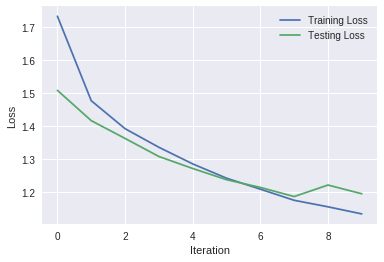

In [31]:
modeleval.plot_loss()

# Filter Visualization

In [0]:
from torchvision import utils

In [0]:
def vistensor(tensor, ch=0, nrow=20, padding=1): 
    '''
    https://github.com/pedrodiamel/nettutorial/blob/master/pytorch/pytorch_visualization.ipynb

    ''' 
    
    n,c,w,h = tensor.shape
    if c != 3:
      tensor = tensor.view(n*c,-1,w,h )
      tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min((tensor.shape[0]//nrow + 1, 64 ) )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

torch.Size([20, 3, 5, 5])


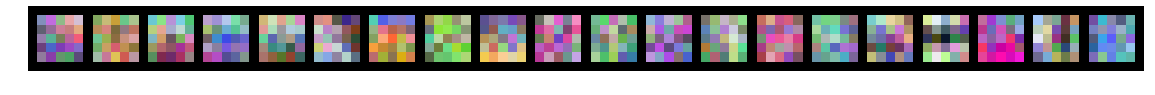

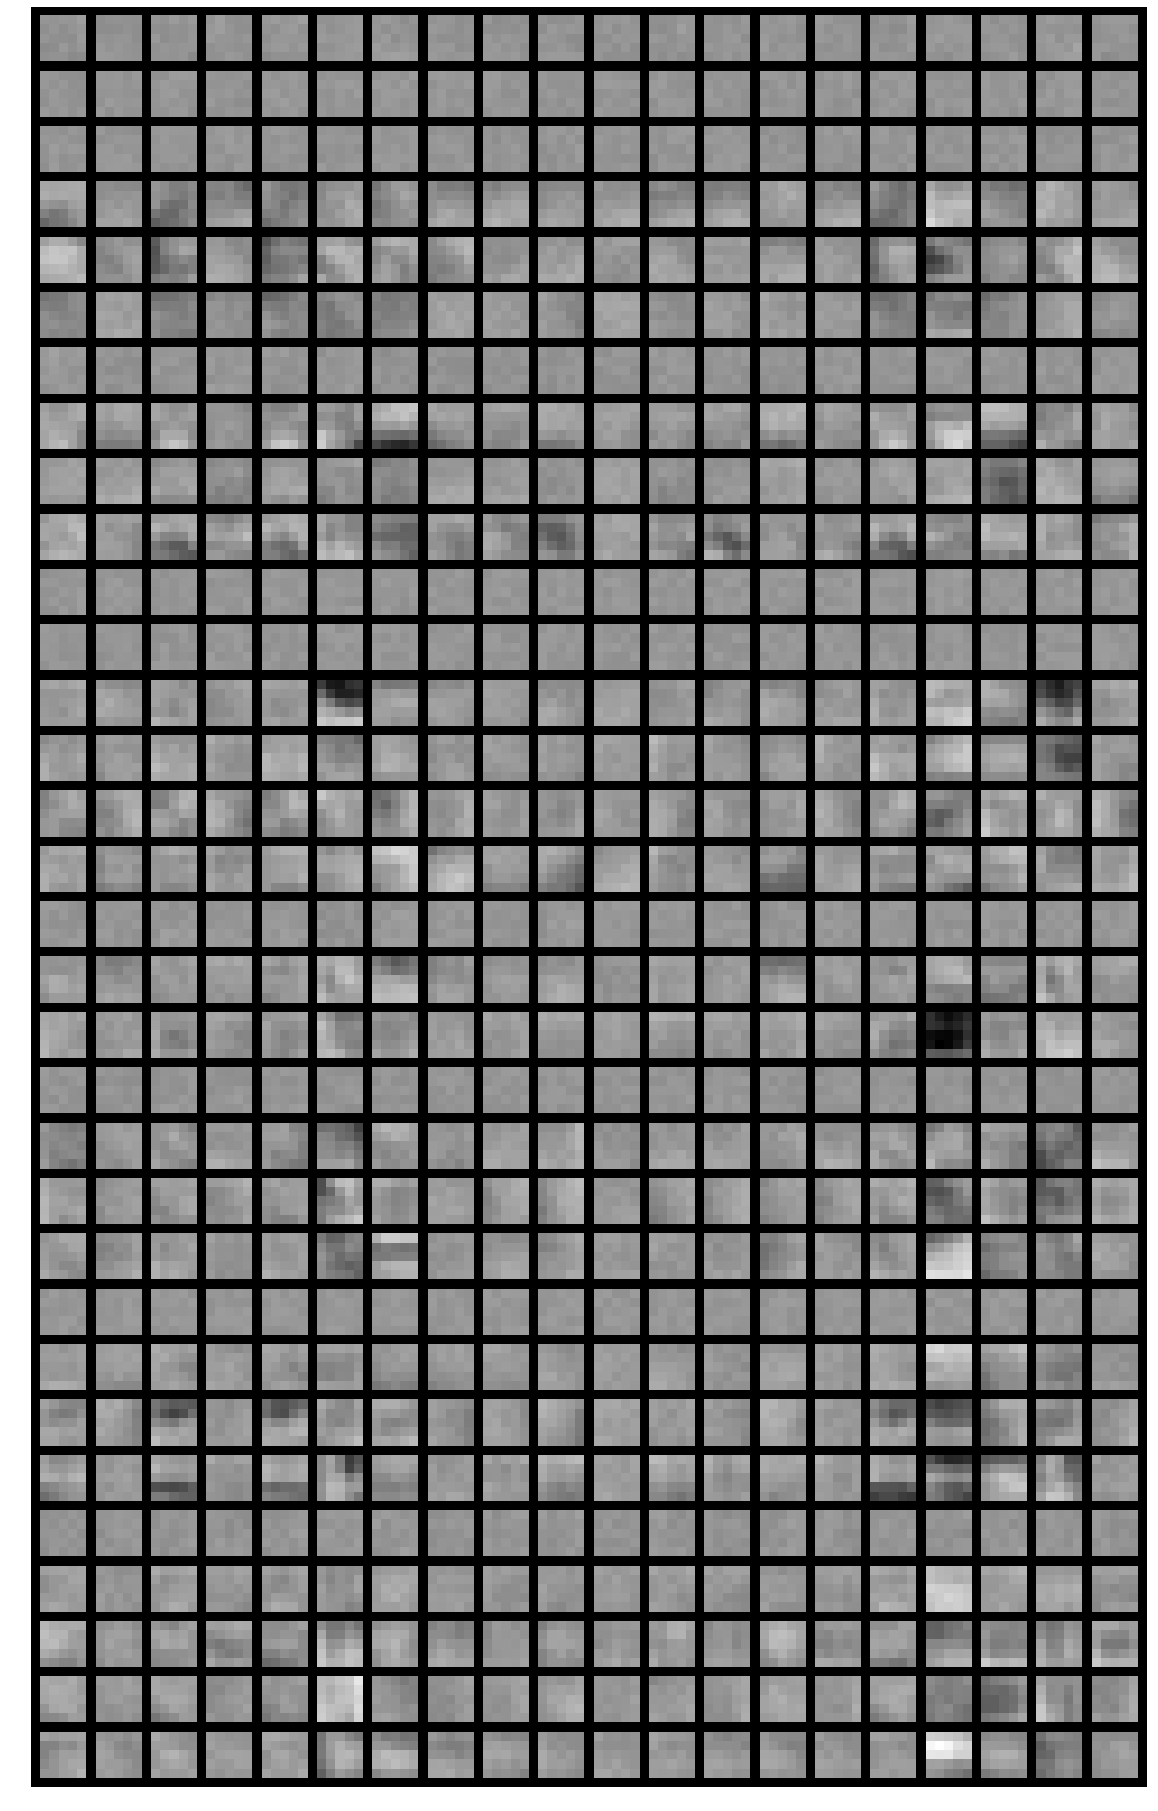

In [149]:

filters = model.modules()
model_layers = [i for i in model.children()]
first_layer = model_layers[0]
second_layer = model_layers[4]

first_kernels = first_layer.weight.data.clone()
print(first_kernels.shape)
vistensor(first_kernels)
plt.axis('off')
plt.ioff()
plt.show()

second_kernels = second_layer.weight.data.clone()
vistensor(second_kernels)
plt.axis('off')
plt.ioff()
plt.show()

## Visualize output of CNN

torch.Size([20, 28, 28])
Output Layer 1


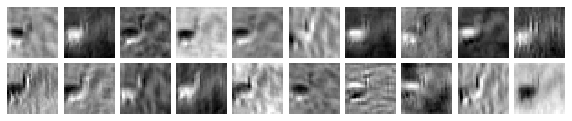

Output Layer 2


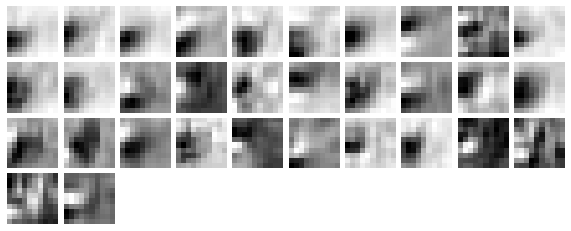

In [117]:
def plot_img(tensor, num_cols=10):
  num_kernels = tensor.shape[0]
  num_rows = 1+ num_kernels // num_cols
  fig = plt.figure(figsize=(num_cols,num_rows))
  for i in range(num_kernels):
    ax1 = fig.add_subplot(num_rows,num_cols,i+1)
    ax1.imshow(tensor[i], cmap='gray')
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()    
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

for image in images[:1]:
  image = image.view(1, 3, 32, 32)
  out1, out2 = model.output_cnn(image.to(modeleval.device))
  out1, out2 = out1.squeeze(), out2.squeeze()
  
  # show images
  print(out1.shape)
  print('Output Layer 1')
  plot_img(out1.detach().numpy())
  print('Output Layer 2')
  plot_img(out2.detach().numpy())